# Time series handling  

<div style="text-align: right"><img src="./dash-apps/pyLife_logo_20200219_FINAL_RGB.png" width="250" /></div>


This Notebook shows a general calculation stream for time series. You will see how to 
* read in time series
* plot the data in time and frequency domain
* filter the time series with a bandpass filter
* remove spikes using running statistics
* calculate and plot the rainflow matrices of the time series
* combine the PSD to an envelope PSD.

If you have any question feel free to contact [us](mailto:DanielChristopher.Kreuter@de.bosch.com).

In [1]:
import numpy as np
import pandas as pd

import pylife.stress.histogram as psh
import pylife.stress.timesignal as ts
import pylife.stress.rainflow as RF
import pylife.stress.rainflow.recorders as RFR
import pickle

import pyvista as pv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

from scipy import signal as sg

# mpl.style.use('seaborn')
mpl.style.use('bmh')
get_ipython().run_line_magic('matplotlib', 'inline')

some functionality to plot the rainflow matrices

In [18]:
from helper_functions import plot_rf

### Time series signal ###
import, filtering and so on. You can import your own signal with

* [pd.read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)
* [pd.read_excel()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html)
* [scipy.io.loadmat()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) for matlab files 

and so on

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>], dtype=object)

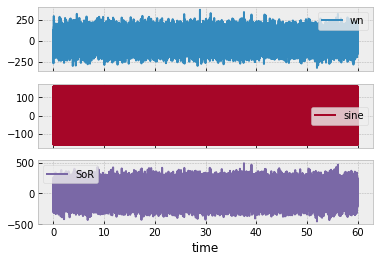

In [3]:
np.random.seed(4711)
sample_frequency = 1024
t = np.linspace(0, 60, 60 * sample_frequency)
signal_df = pd.DataFrame(data = np.array([80 * np.random.randn(len(t)),
                                          160 * np.sin(2 * np.pi * 50 * t)]).T,
                         columns=["wn", "sine"],
                         index=pd.Index(t, name="time"))
signal_df["SoR"] = signal_df["wn"] + signal_df["sine"]
signal_df.plot(subplots=True)

<AxesSubplot:title={'center':'PSD of time series'}, xlabel='frequency', ylabel='PSD'>

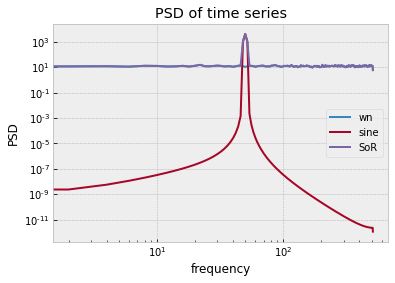

In [4]:
ts.psd_df(signal_df, NFFT = 512).plot(loglog=True, ylabel="PSD", title="PSD of time series")

### Filtering 
We are using a butterworth bandpass filter from [scipy.signal](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) to filter the time series.

In [5]:
f_min = 5.0    # Hz
f_max = 100.0  # Hz

<AxesSubplot:title={'center':'PSD of filtered time series'}, xlabel='frequency', ylabel='PSD bandpassed'>

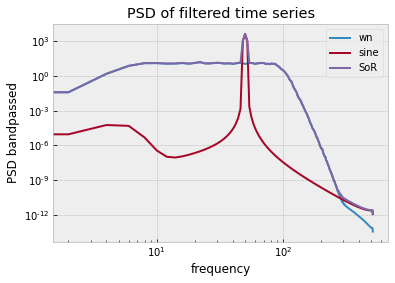

In [6]:
bandpass_df = ts.butter_bandpass(signal_df, f_min, f_max)

df_psd = ts.psd_df(bandpass_df, NFFT = 512)
df_psd.plot(loglog=True, ylabel="PSD bandpassed", title="PSD of filtered time series")

### Running statistics

First we create a spike in our existing data set

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

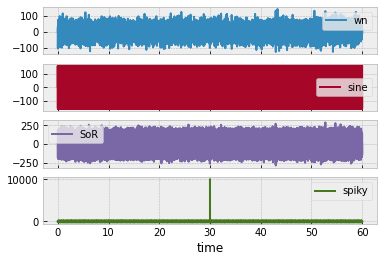

In [7]:
bandpass_df["spiky"] = bandpass_df["sine"] + 1e4 * sg.unit_impulse(signal_df.shape[0], idx="mid")
bandpass_df.plot(subplots=True)

Now we want to clean this spike automatically

C:\python\pyLife\_venv\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
Feature Extraction: 100%|██████████████████████████████████████████████████████████| 244/244 [00:00<00:00, 6784.47it/s]


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

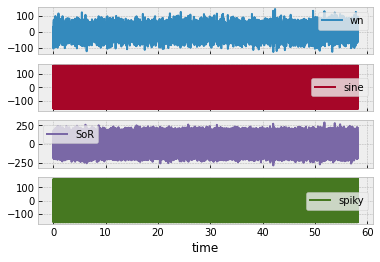

In [8]:
cleaned_df = ts.clean_timeseries(bandpass_df, "spiky", window_size=1024, overlap=32,
                     feature="maximum", method="remove", n_gridpoints=3,
                     percentage_max=0.05, order=3).drop(["time"], axis=1)

cleaned_df.plot(subplots=True)

### Rainflow ###
The [rainflow module](https://pylife.readthedocs.io/en/latest/stress/rainflow.html) in pyLife can be used with different counting methods:

* FKM
* Three point
* Four point enhanced

In [9]:
rainflow_bins = 10

In [10]:
#%% Rainflow for a multiple time series
recorder_dict = {key: RFR.FullRecorder() for key in cleaned_df}
detector_dict = {key: RF.FKMDetector(recorder=recorder_dict[key]).process(cleaned_df[key]) for key in cleaned_df}
rf_series_dict = {key: detector_dict[key].recorder.matrix_series(rainflow_bins) for  key in detector_dict.keys()}

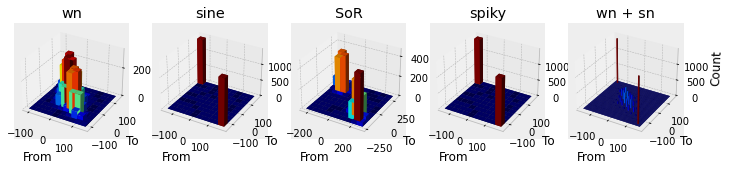

In [19]:
f = plot_rf(rf_series_dict)

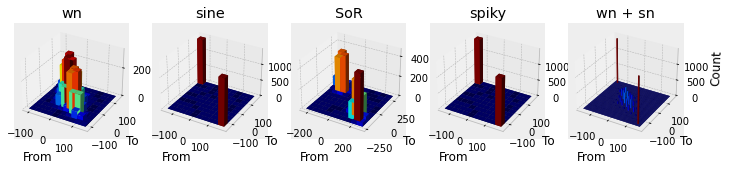

In [12]:
#%% Now Combining different RFs to one
rf_series_dict["wn + sn"] = psh.combine_hist([rf_series_dict["wn"],rf_series_dict["sine"]],
                                             method="sum")
f = plot_rf(rf_series_dict)

### PSD combinig
It is also possible to combine spectra

<AxesSubplot:xlabel='frequency', ylabel='PSD'>

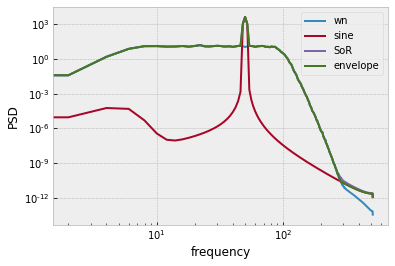

In [13]:
df_psd["envelope"] =  df_psd[["sine", "wn"]].max(axis = 1)
df_psd.plot(loglog=True, ylabel="PSD")

### Saving

Now we saving the rainflow data into a pickle file.
If you want to have an introduction to damage and failure probability calculation, please have a look on the notebook [lifetime_calc](http://localhost:8888/notebooks/lifetime_calc.ipynb)

In [17]:
rf_out = {k: rf_series_dict[k] for k in ["wn", "sine", "SoR"] if k in rf_series_dict}
pickle.dump(rf_out, open("rf_dict.p", "wb"))